# Problem statement

Our goal is to create a model that can predict the result of football matches using statistics of shots. Very often it happens that a result of a football match does not reflect the essence of what was happening. It's a common situation, when the final score is, for example, 0-0, and, at the same time, the first team didn't leave the opposite side of the pitch, while the second team "packed the bus" in front of their goal.

# Getting the data

In [44]:
import matplotlib.image as image
from matplotlib import pyplot as plt
import pylab
%matplotlib inline
import requests
import re
import json
import pandas as pd
from selenium import webdriver
from time import sleep
headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:45.0) Gecko/20100101 Firefox/45.0',
           'Cookie':'_ga=GA1.2.1788983733.1494503736; __gads=ID=2e4df19361f00591:T=1494503737:S=ALNI_MZ7Jd9M7q36WcBgqgMh0yJSQNa6Wg; visid_incap_774904=aGiPnvmhSRGPczacK1cgNAX6FVkAAAAAQUIPAAAAAADmwCV94oxpNGVNRrg+85Nz; visid_incap_774906=oDRL9OxQTfe/VVjCv89aQrQMFlkAAAAAQUIPAAAAAAAiSlrJLiCEdb8MIUmclKOM; vg=75ef9e42-4041-498a-ad3e-11d0dfda90bc; ip=1845259694; vl=1:-3.00|2:RU|3:MOSKVA|4:|5:MOSKVA/|6:MOSKVA/MOSCOW|7:101990|!0; vd=mgts.ru; incap_ses_580_774904=f6NkYU1V3BOczXPdKZMMCDA4SFkAAAAADbatmVBaxc34df1J9oYPjQ==; _gid=GA1.2.2091836470.1497905203'}

First of all, let's write a function that extracts information about a particular match from WhoScored given its id:

In [6]:
def get_match_info(match_url):
    response = requests.get(match_url,headers=headers)
    regex = re.compile("var matchCentreData = (\{.+\});\r\n        var matchCentreEventTypeJson", re.S)
    match = re.search(regex, response.text)
    match_id = re.findall(r'\d+', match_url)[0]
    match_dict = json.loads(match.groups(1)[0])
    match_dict['match_id'] = match_id
    
    teams_info = re.findall('matchHeader.load\(\[(.+)\]\r', response.text)[0].split(',')
    match_dict['home_team_name'] = teams_info[2][1:-1]
    match_dict['away_team_name'] = teams_info[3][1:-1]

    return match_dict

The output result is a huge list of information about each event that occurred during the match. Every event is given a list of numbers *satisfiedEventsTypes*, characterizing its type (for example, 7 means that some event describes shotOnPost, 11 - right-footed shot). For example, 'satisfiedEventsTypes': [90, 116, 29, 34, 36, 215, 217] means that this event is an accurate short BackPass made in the mid third of the pitch. See *matchCentreEventType.txt* for the full list of attributes. 

Since we are interested only in shots, we need to handle events that contain 9 ("shotsTotal" events).

In [3]:
def parse_shots_from_match(match_info):
    match_id = match_info['match_id']
    home_id = match_info['home']['teamId']
    away_id = match_info['away']['teamId']
    player_ids = match_info['playerIdNameDictionary']
    
    shots = []
    for event in match_info['events']:
        if 9 in event['satisfiedEventsTypes']:
            minute = event['minute']
            
            player_id = str(event['playerId'])
            player_name = player_ids[player_id]
            x_coord = event['x']
            y_coord = event['y']
        
            goalMouthY = ''
            goalMouthZ = ''
            try:
                goalMouthY = event['goalMouthY']
                goalMouthZ = event['goalMouthZ']
            except:
                pass
        
            is_big_chance = 0
            is_from_corner = 0
            is_freekick = 0
            is_penalty = 0
            if 'qualifiers'  in event:
                for q in event['qualifiers']:
                    if q['type']['displayName'] == 'BigChance':
                        is_big_chance = 1
                    if q['type']['displayName'] == 'FromCorner':
                        is_from_corner = 1
                    if q['type']['displayName'] ==  'DirectFreekick':
                        is_freekick = 1
                    if q['type']['displayName'] == 'Penalty':
                        is_penalty = 1
        
            is_open_play = int(3 in event['satisfiedEventsTypes'])
            is_counter = int(4 in event['satisfiedEventsTypes'])
            is_set_piece = int(5 in event['satisfiedEventsTypes'])
            is_goal = int(('isGoal' in event) and (event['isGoal']==True))
            is_shot_on_target = int(8 in event['satisfiedEventsTypes'])
            is_blocked = int(10 in event['satisfiedEventsTypes'])
        
            shot_type = 0
            if 11 in event['satisfiedEventsTypes']:
                shot_type = 1
            if 12 in event['satisfiedEventsTypes']:
                shot_type = 1
            if 13 in event['satisfiedEventsTypes']:
                shot_type = 2
        
            shots.append([match_id, event['teamId'], player_id, player_name, minute, x_coord, y_coord, goalMouthY, goalMouthZ,
                          shot_type, is_big_chance, is_from_corner, is_open_play, is_counter, is_set_piece, is_freekick, 
                          is_penalty, is_shot_on_target, is_blocked, is_goal])

    return shots

In [4]:
def represent(shots_list):
    return pd.DataFrame(shots_list, columns=['match_id', 'team_id', 'player_id', 'player_name', 'minute', 'x', 'y', 
                'goalMouthY', 'goalMouthZ', 'shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter', 
                'is_set_piece', 'is_freekick', 'is_penalty', 'is_on_target', 'is_blocked', 'is_goal'])

Now we have an instrument to get all the needed information about a particular football match. But we are going to parse hundreds of matches, so we should create something to extract many ids per one action, without collecting them manually. The best way to do that is to use Selenium:

In [5]:
def get_tournament_urls(tournament_url):
    driver = webdriver.Chrome('/home/saint/Рабочий стол/chromedriver')
    driver.get(tournament_url)
    
    match_urls = []
    
    while True:
        month = driver.find_elements_by_class_name("text")[4].text
        matches = driver.find_elements_by_class_name("result-1")
        for match in matches:
            match_urls.append(match.get_attribute('href'))
        driver.find_element_by_xpath("""//*[@id="date-controller"]/a[1]""").click()
        month_new = driver.find_elements_by_class_name("text")[4].text
        if month_new == month:
            break
        month = month_new
        sleep(2)
    return match_urls

In [6]:
matches = get_tournament_urls('https://www.whoscored.com/Regions/182/Tournaments/77/Seasons/6357/Stages/13823/Fixtures/Russia-Premier-League-2016-2017')

In [7]:
from tqdm import tqdm
shots = []
for match in tqdm(matches):
    try:
        shots += parse_shots_from_match(get_match_info(match))
        sleep(0.5)
    except:
        pass

100%|██████████| 240/240 [09:58<00:00,  2.34s/it]


In [8]:
pd.DataFrame(shots, columns=['match_id', 'team_id', 'player_id', 'player_name', 'minute', 'x', 'y', 'goalMouthY', 'goalMouthZ', 'shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter', 'is_set_piece', 'is_freekick', 'is_penalty', 'is_on_target', 'is_blocked', 'is_goal']).to_csv('data/shots_rfpl_2016-2017.csv', index=False)

# Dataset summary

We used parser described above to download information about shots from top-3 leagues (EPL, La Liga, Bundesliga) from 2010-2017 seasons, 198740 in total. The number of features is 20 (match id, team id, player id, player name, minute, coordinates, shot type, is big chance, is from corner, is open play, is counter, is set piece, is freekick, is penalty, is on target, is blocked, is goal)

#  Training the model

So, we need to predict the probability, that given shot would lead to a goal. We decided to use Logistic regression for this task.

First of all, we need to concatenate all the data csv files (as we have a separate csv for each season).

In [7]:
import numpy as np
from os import listdir
seasons = []
for file in listdir('/home/saint/Рабочий стол/Football Analytics/ignatov/data'):
    seasons.append(pd.read_csv('data/'+file))
a = pd.concat(seasons)

Then let's add some more features - the distance to the goal and the angle under which the goal was visible:

In [5]:
a = a[a['is_penalty'] == 0]
a.loc[a['shot_type'] == 0,'shot_type'] = 1
x = a[['x', 'y', 'shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter', 'is_set_piece', 'is_freekick']]
x.is_copy = False
x['distance'] = np.sqrt((100-a['x'])**2+((100-a['y'])/100*63)**2)
x['y'] = abs(x['y']-50).values
y = a['is_goal']

In [6]:
x = pd.get_dummies(data=x, columns=['shot_type'])
x = x.values
y = y.values

In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=20)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 1.39)
lr.fit(X_train, y_train)

LogisticRegression(C=1.39, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's save it 

In [9]:
from sklearn.externals import joblib
joblib.dump(lr, 'LogisticRegression.pkl') 

['LogisticRegression.pkl']

# Visualizing shots

Let's create a map of the football field, which will show the shots. The size of the circle characterizing the shot will be proportional to xG

In [8]:
from matplotlib import patches
def goalMouth_map(coord_list, is_goal_list):

    fig,ax = plt.subplots(1)
    fig.set_size_inches(15, 3.9, forward=True)

    pylab.ylim([0,55])
    pylab.xlim([-10,10])

    rect = patches.Rectangle((-4.9,0),9.8,38.5,linewidth=7,edgecolor='k',facecolor='none')
    ax.add_patch(rect)

    for c, shot in enumerate(coord_list):
        color = '.g' if is_goal_list[c] == 1 else '.r'
        plt.plot(50-shot[0], shot[1], color )
    plt.show()

In [9]:
def shots_map(coord_list, is_goal_list, is_home_list, xG_list = False, score='', home_team_name='', away_team_name='',
             xG_score=''):
    PITCH_LENGTH = 152
    
    fig,ax = plt.subplots(1)
    ax.set_facecolor('#65AA1F')
    fig.set_size_inches(13, 15, forward=True)
    plt.gca().set_aspect('equal', adjustable='box')
    pylab.ylim([0,110])
    pylab.xlim([0,PITCH_LENGTH])

    plt.plot([50*PITCH_LENGTH/100, 50*PITCH_LENGTH/100], [0, 100], 'k-', lw=2)
    plt.plot([0, 16.2*PITCH_LENGTH/100], [20, 20], 'k-', lw=2)
    plt.plot([0, 16.2*PITCH_LENGTH/100], [80, 80], 'k-', lw=2)
    plt.plot([16.2*PITCH_LENGTH/100, 16.2*PITCH_LENGTH/100], [20, 80], 'k-', lw=2)
    plt.plot([100*PITCH_LENGTH/100, 83.8*PITCH_LENGTH/100], [20, 20], 'k-', lw=2)
    plt.plot([100*PITCH_LENGTH/100, 83.8*PITCH_LENGTH/100], [80, 80], 'k-', lw=2)
    plt.plot([83.8*PITCH_LENGTH/100, 83.8*PITCH_LENGTH/100], [20, 80], 'k-', lw=2)
    plt.plot([0, 5.5*PITCH_LENGTH/100], [36.33, 36.33], 'k-', lw=2)
    plt.plot([0, 5.5*PITCH_LENGTH/100], [63.67, 63.67], 'k-', lw=2)
    plt.plot([5.5*PITCH_LENGTH/100, 5.5*PITCH_LENGTH/100], [36.33, 63.67], 'k-', lw=2)
    plt.plot([100*PITCH_LENGTH/100, 94.5*PITCH_LENGTH/100], [36.33, 36.33], 'k-', lw=2)
    plt.plot([100*PITCH_LENGTH/100, 94.5*PITCH_LENGTH/100], [63.67, 63.67], 'k-', lw=2)
    plt.plot([94.5*PITCH_LENGTH/100, 94.5*PITCH_LENGTH/100], [36.33, 63.67], 'k-', lw=2)
    plt.plot([0, 0], [44.54, 55.46], 'k-', lw=5)
    plt.plot([100*PITCH_LENGTH/100, 100*PITCH_LENGTH/100], [44.54, 55.46], 'k-', lw=5)
    plt.plot(11.5*PITCH_LENGTH/100,50, '.k')
    plt.plot(88.5*PITCH_LENGTH/100,50, '.k')
    plt.plot([0, 100*PITCH_LENGTH/100], [100, 100], 'k-', lw=2)
    circle=plt.Circle((50*PITCH_LENGTH/100,50),14.5, fill=False)
    ax.add_artist(circle)
    
    rect = patches.Rectangle((0,100),PITCH_LENGTH,10,linewidth=1,color='w')
    ax.add_patch(rect)
    
    plt.text(15,104,home_team_name, size=20, horizontalalignment='left')
    plt.text(PITCH_LENGTH-15,104,away_team_name, size=20, horizontalalignment='right')
    plt.text(PITCH_LENGTH/2,106,score, size=15, horizontalalignment='center')
    plt.text(PITCH_LENGTH/2,102,xG_score, size=15, horizontalalignment='center')
    
    for c, shot in enumerate(coord_list):
        color = '.g' if is_goal_list[c] == 1 else '.r'
        if type(xG_list) == bool:
            markersize = 30
        else:
            markersize = 50*np.sqrt(xG_list[c])
        if is_home_list[c] == 0:
            x = shot[0]*PITCH_LENGTH/100
            y = shot[1]
        else:
            x = (100-shot[0])*PITCH_LENGTH/100
            y = 100-shot[1]
        plt.plot(x, y, color, markersize=markersize, markeredgecolor='k')
    plt.savefig('testplot.png', bbox_inches='tight', pad_inches=0)
    plt.show()

In [10]:
from os import listdir
seasons = []
for file in listdir('/home/saint/Рабочий стол/Football Analytics/ignatov/data'):
    seasons.append(pd.read_csv('data/'+file))
a = pd.concat(seasons)

Let's plot some random shots:

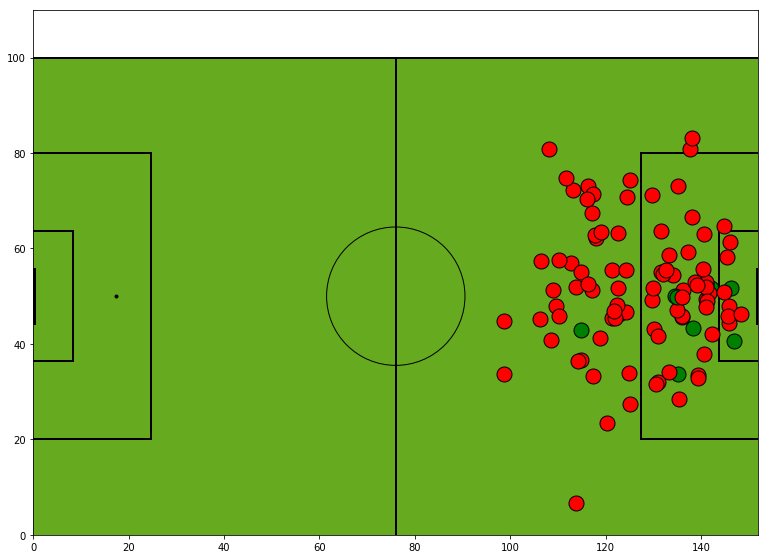

In [19]:
shots_map(a[['x', 'y']].values[:100], a[['is_goal']].values[:100], np.zeros(100))

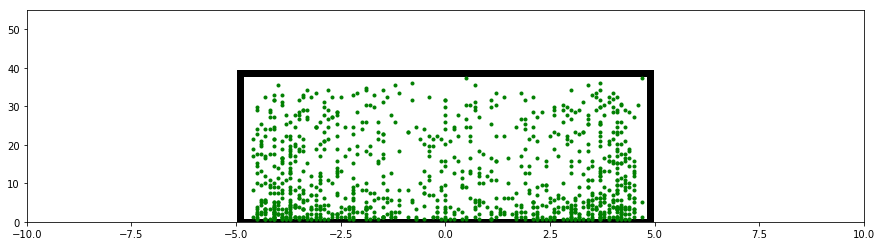

In [26]:
goalMouth_map(a[a['is_goal'] == 1][['goalMouthY', 'goalMouthZ']].values[:1000], 
              a[a['is_goal'] == 1][['is_goal']][:1000].values)

# Predicting xG

Now we can predict xG. Let's write some helpful functions for it:

In [29]:
from sklearn.externals import joblib
lr = joblib.load('LogisticRegression.pkl') 

In [30]:
def get_shot_xG(shot):
    return lr.predict_proba(shot.reshape(1,-1))[:,1][0]

In [31]:
def get_list_xG(shots):
    xG_list = []
    for shot in shots:
        xG_list.append(get_shot_xG(shot))
    return xG_list

In [32]:
def get_match_xG(match_url):
    match_info = get_match_info(match_url)
    
    score = match_info['score'] 
    home_team_id = match_info['home']['teamId']
    away_team_id = match_info['away']['teamId']
    home_team_name = match_info['home_team_name']
    away_team_name = match_info['away_team_name']

    df = represent(parse_shots_from_match(match_info))
    shot_data = df[['team_id', 'x', 'y', 'shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter',
                    'is_set_piece', 'is_freekick']]
    shot_data.is_copy = False
    shot_data['distance'] = np.sqrt((100-shot_data['x'])**2+((100-shot_data['y'])/100*63)**2)
    shot_data['y'] = abs(shot_data['y']-50)
    shot_data = pd.get_dummies(data=shot_data, columns=['shot_type']).drop('team_id', axis=1).values
    df['xG'] = get_list_xG(shot_data)

    home_pens = df[(df['is_penalty'] == 1) & (df['team_id'] == home_team_id)]['is_penalty'].sum()
    away_pens = df[(df['is_penalty'] == 1) & (df['team_id'] == away_team_id)]['is_penalty'].sum()
    df_no_pen = df[df['is_penalty'] == 0]
    home_xG = df_no_pen[df_no_pen['team_id'] == home_team_id]['xG'].sum()
    away_xG = df_no_pen[df_no_pen['team_id'] == away_team_id]['xG'].sum()
    xG_score = '(%0.2f ' % (home_xG)
    if home_pens != 0:
        xG_score += '(+%d pen) ' % (home_pens)
    xG_score += ': %0.2f' % (away_xG)
    if away_pens != 0:
        xG_score += ' (+%d pen)' % (away_pens)
    xG_score += ')'

    shots_info = df_no_pen[['x', 'y', 'is_goal', 'xG', 'team_id']]
    shots_info['home_team'] = (shots_info['team_id'] == home_team_id).astype(int)
    shots_info = shots_info.values
    shots_map(shots_info[:,:2], shots_info[:,2], shots_info[:,5], shots_info[:,3], score=score,
              home_team_name=home_team_name, away_team_name=away_team_name, xG_score=xG_score)
    return df

Now we've got an instrument, that can plot the next pictures given the id of the match:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


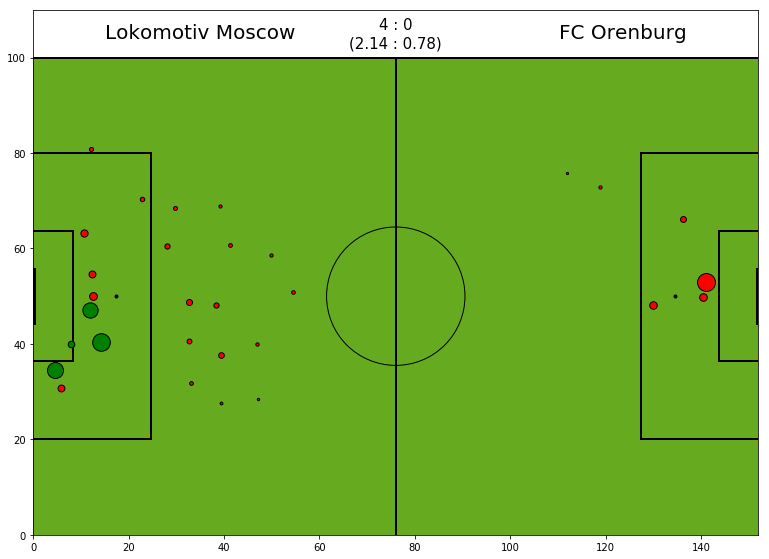

In [67]:
import numpy as np
a = get_match_xG('https://www.whoscored.com/Matches/1083840/Live/Russia-Premier-League-2016-2017-Lokomotiv-Moscow-FC-Orenburg')

# Practical implementation

Now let's analyze the results of the RFPL 2016/17:

In [139]:
rfpl = pd.read_csv('data/shots_rfpl_2016-2017.csv')

In [140]:
#rfpl = pd.DataFrame(shots, columns=['match_id', 'team_id', 'player_id', 'player_name', 'minute', 'x', 'y', 'goalMouthY', 'goalMouthZ', 'shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter', 'is_set_piece', 'is_freekick', 'is_penalty', 'is_on_target', 'is_blocked', 'is_goal'])
rfpl = rfpl[rfpl['is_penalty'] == 0]

In [141]:
import numpy as np
shot_data = rfpl[['x', 'y', 'shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter',
                    'is_set_piece', 'is_freekick']]
shot_data.is_copy = False
shot_data['distance'] = np.sqrt((100-shot_data['x'])**2+((100-shot_data['y'])/100*63)**2)
shot_data['y'] = abs(shot_data['y']-50)
shot_data.loc[shot_data['shot_type'] == 0,'shot_type'] = 1
shot_data = pd.get_dummies(data=shot_data, columns=['shot_type']).values
rfpl['xG'] = get_list_xG(shot_data)

In [142]:
teams = {560:'Zenit', 562:'Rostov', 668:'Lokomotiv', 840:'Spartak', 847:'CSKA', 997:'Krylya Sovetov', 1002:'Anzhi', 
        1537:'Amkar', 2057:'Rubin', 2288:'Tom', 2407:'Akhmat', 4174:'Ural', 5460:'Orenburg',7164:'Krasnodar', 
         8753:'Arsenal', 9004:'Ufa'}
rfpl = rfpl.replace({'team_id':teams})

Let's find which team created most moments during the 2016/2017 season:

In [143]:
rfpl.groupby('team_id')[['xG']].sum().sort_values('xG', ascending=False)

,xG
team_id,
Zenit,39.463513
Spartak,34.953309
CSKA,34.209945
Krylya Sovetov,32.627794
Krasnodar,28.733859
Rubin,28.443868
Akhmat,28.307419
Lokomotiv,27.484959
Rostov,25.460197


Now let's find which teams and players have the best realisation (xG/goal value)

In [144]:
scorers = rfpl.groupby('player_name')[['is_goal']].sum().reset_index()
xG = rfpl.groupby('player_name')[['xG']].sum().reset_index()

In [147]:
xG_scorers = scorers.merge(xG, on='player_name', how='left')
xG_scorers = xG_scorers[xG_scorers['is_goal'] >= 6]
xG_scorers['xG/goal'] = xG_scorers['xG'].values / xG_scorers['is_goal'].values

In [148]:
xG_scorers.sort_values('xG/goal', ascending=False)

,player_name,is_goal,xG,xG/goal
208,Jonathas,8,7.302729,0.912841
69,Artem Dzyuba,12,9.869438,0.822453
320,Sergei Kornilenko,8,6.508737,0.813592
289,Quincy Promes,10,7.728812,0.772881
84,Bekim Balaj,9,6.100799,0.677867
314,Sardar Azmoun,7,4.621045,0.660149
211,Kehinde Fatai,6,3.952992,0.658832
1,Ablae Mbengue,7,4.538930,0.648419
66,Ari,10,6.325549,0.632555
235,Maksim Kanunnikov,7,4.217184,0.602455


In [73]:
xG = rfpl.groupby('team_id')[['xG']].sum().reset_index()
goals = rfpl.groupby('team_id')[['is_goal']].sum().reset_index()
xG_goals = goals.merge(xG, on='team_id', how='left')
xG_goals['xG/goal'] = xG_goals['xG'].values / xG_goals['is_goal'].values
xG_goals.sort_values('xG/goal')
xG_goals['goal_per_match'] = xG_goals['is_goal'].values/30
xG_goals['xG_per_match'] = xG_goals['xG'].values/30
xG_goals

,team_id,is_goal,xG,xG/goal,goal_per_match,xG_per_match
0,Akhmat,35,28.307419,0.808783,1.166667,0.943581
1,Amkar,20,18.286895,0.914345,0.666667,0.609563
2,Anzhi,18,21.004646,1.166925,0.600000,0.700155
3,Arsenal,15,19.062218,1.270815,0.500000,0.635407
4,CSKA,43,34.209945,0.795580,1.433333,1.140332
5,Krasnodar,34,28.733859,0.845114,1.133333,0.957795
6,Krylya Sovetov,25,32.627794,1.305112,0.833333,1.087593
7,Lokomotiv,31,27.484959,0.886612,1.033333,0.916165
8,Orenburg,21,23.539696,1.120938,0.700000,0.784657
9,Rostov,35,25.460197,0.727434,1.166667,0.848673


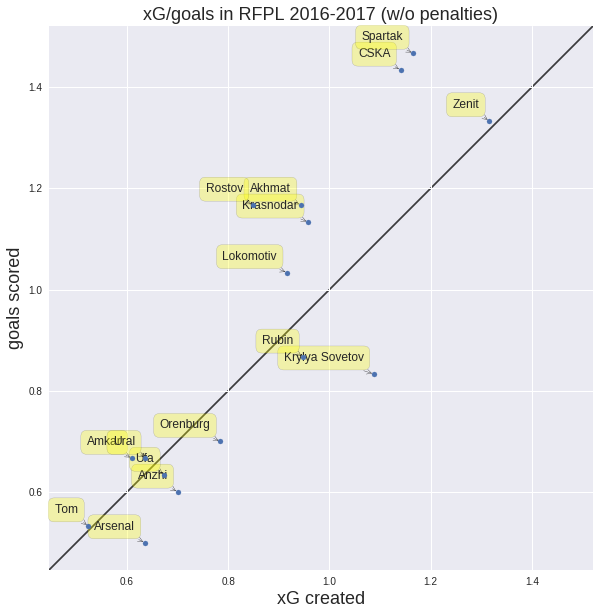

In [113]:
import seaborn as sn
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(xG_goals['xG_per_match'], xG_goals['goal_per_match'],s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

for label, x, y in zip(xG_goals['team_id'].values, xG_goals['xG_per_match'].values, xG_goals['goal_per_match'].values):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.title('xG/goals in RFPL 2016-2017 (w/o penalties)', fontsize=18)
plt.xlabel('xG created', fontsize=18)
plt.ylabel('goals scored', fontsize=18)

So, if we trained our model pretty accurate, there should be about 1 xG needed to score a goal. Let's check it:

In [120]:
a['is_goal'].sum() / a['xG'].sum()

1.0004537589622886

In [127]:
a.groupby('player_name')[['xG']].sum().sort_values('xG', ascending=False).head(2)

,xG
player_name,
Cristiano Ronaldo,172.684624
Lionel Messi,171.071551


Even in this parameter they're are the best and very close to each other!

In [130]:
a.groupby('player_name')[['is_goal']].sum().sort_values('is_goal', ascending=False).head(2)

,is_goal
player_name,
Lionel Messi,222
Cristiano Ronaldo,205


(But Messi scored more)

In [149]:
a[a['shot_type'] != 0].groupby('shot_type')[['xG']].mean()

,xG
shot_type,
1,0.093324
2,0.113850


Headers are more dangerous than kicks, as they are performed from closer distance (in average):

Let's find players with the best realisation coefficient among those  who scored more than 70 goals in the last 7 seasons:

In [197]:
total = a.groupby('player_name').count()[['x']].reset_index()
xG = a.groupby('player_name')[['xG']].sum().reset_index()
goals = a.groupby('player_name')[['is_goal']].sum().reset_index()
players = total.merge(xG, on='player_name', how='left').merge(goals, on='player_name', how='left')
players['xG/goal'] = players['xG']/players['is_goal']
players = players[players['is_goal'] > 70][['player_name', 'xG/goal']].sort_values('xG/goal')
players

,player_name,xG/goal
1198,Gareth Bale,0.722369
183,Alexis Sánchez,0.745802
2022,Lionel Messi,0.770593
2194,Marco Reus,0.775686
284,Antoine Griezmann,0.792280
867,Diego Costa,0.796206
2063,Luis Suárez,0.837291
664,Cristiano Ronaldo,0.842364
3495,Wayne Rooney,0.862584
2964,Romelu Lukaku,0.865202


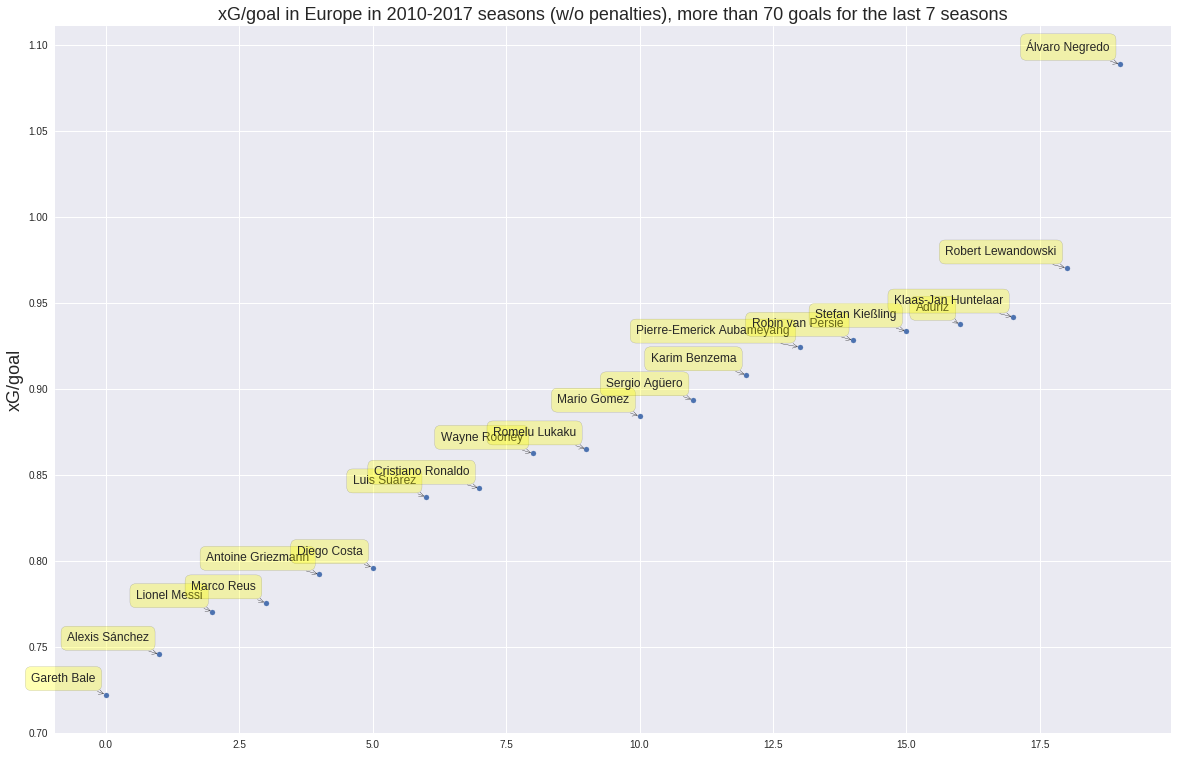

In [209]:
fig, ax = plt.subplots(figsize=(20, 13))
plt.scatter(np.arange(0,players.shape[0]), players['xG/goal'],s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

for label, x, y in zip(players['player_name'].values, np.arange(0,players.shape[0]), players['xG/goal'].values):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.title('xG/goal in Europe in 2010-2017 seasons (w/o penalties), more than 70 goals for the last 7 seasons', fontsize=18)
plt.ylabel('xG/goal', fontsize=18)

# Comparison with other models

Let's calculate RMSE:

In [56]:
a = a[a['is_penalty'] == 0]
shot_data = a[['x', 'y', 'shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter',
                    'is_set_piece', 'is_freekick']]
shot_data.is_copy = False
shot_data['distance'] = np.sqrt((100-shot_data['x'])**2+((100-shot_data['y'])/100*63)**2)
shot_data['y'] = abs(shot_data['y']-50)
shot_data.loc[shot_data['shot_type'] == 0,'shot_type'] = 1
shot_data = pd.get_dummies(data=shot_data, columns=['shot_type']).values
a['xG'] = get_list_xG(shot_data)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [57]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(a['is_goal'].values, a['xG'].values))

0.26511717771381915

Pretty good result (Michael Caley, the guru of xG, got 0.258 in 2015 : https://twitter.com/mc_of_a/status/636957129992216577)

# Summary 
xG-model is a very useful tool for detailed and objective analysis, as well as for long-term predictions. As practice shows, this system can be useful not only for football fans but also for clubs. Probably, soon, the owners of football clubs will use this model to assess the work of the coach, and the coach will use xG to select tactics for the match. This will be a significant step forward from the current situation, in which most decisions are made on the basis of public opinion and random factors.